# Convolution-type MKV-SDE

In [ ]:
import scipy
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA
from numpy import mean

def factorial(n):
    if n == 1:
        return [1, 1]
    else:
        return factorial(n-1)+[math.factorial(n)]
    
def fun_alpha(K, f):
    return lambda x : [math.pi**(1/4) * (1/2)**(i/2) * f[i]**(-1/2) * x**i * np.exp(-(x**2)/4) for i in range(K+1)] 

def fun_alpha1(K, f): 
    return lambda x : [-math.pi**(1/4) * (1/2)**(i/2+1) * f[i]**(-1/2) * x**(i-1) * (x**2 - 2*i) * np.exp(-(x**2)/4) for i in range(K+1)] 

def fun_H(K, f):
    return lambda x : [ (2**i)**(-1/2) * f[i]**(-1/2) * (math.pi)**(-1/4) * (scipy.special.hermite(i, monic=False)(x)) for i in range(K+1)]

def fun_phi1(K, f):
    return lambda x : [-(math.pi)**(-(1/4)) * x, math.sqrt(2)/(math.pi)**(1/4) * (1 - x**2)] + \
        [(2**i)**(-1/2) * f[i]**(-1/2) * (math.pi)**(-1/4) * ( (2 * i * scipy.special.hermite(i-1, monic=False)(x)) - \
                                                              x * (scipy.special.hermite(i, monic=False)(x)) ) for i in range(2,K+1)]


def monte_carlo(sigma, T, N, M, K, f):
    h = T / N
    alpha = fun_alpha(K, f)
    H = fun_H(K, f)
    X = np.random.normal(0, 1, M)
    gamma = np.zeros((K+1, N+1))
    gamma[:,0] = mean( (np.array(H(X)) * np.exp(-((X ** 2)/2))), axis=1 )
    
    for i in range(N):
        W = np.random.normal(0, 1, M) 
        X = X + ( np.dot(gamma[:,i], np.array(alpha(X))) ) * h + sigma * math.sqrt(h) * W
        gamma[:,i+1] = mean( (np.array(H(X)) * np.exp(-((X ** 2)/2))), axis=1 )
    
    return X, gamma 

def base(T, N, n, K, f, tipo):
    g = np.ones(n+1)
    cc = np.linspace(0, T, N+1)
    a = np.zeros((K+1, n+1)) 
    X = np.random.normal(0, 1, 1)
    
    if tipo == 'canonical':
        g = np.array([ cc ** i for i in range(n+1)]) 
        
        a[0,0] = (math.sqrt(2) * math.pi)**(-(1/4))
        
        return a, g
    
    elif tipo == 'lagrange':
        l = [(0 + T)/2 + (T - 0)/2 * np.cos(((2 * i + 1)/ (2 * n + 2)) * math.pi) for i in range(n+1)]
        
        g = np.array([math.prod([((cc - l[j]) / (l[i] - l[j])) for j in range(n+1) if j!=i]) for i in range(n+1)])
        
        a[0,:] = (math.sqrt(2) * math.pi)**(-(1/4))
        
        return a, g 
        
    else:
        return 'err'
    
def euler(a, sigma, n, N, M, h, K, g, alpha, alpha1, H):
    
    Z = np.zeros((N+1, M))
    Ztilde = np.zeros((N+1, M))
    Ytilde = np.zeros((n+1, K+1, N+1, M))
    Tensor = np.zeros((M, K+1, n+1))
    

    Z[0,:] = np.random.normal(0, 1, M) 
    Ztilde[0,:] = np.random.normal(0, 1, M)

    
    for i in range(N):
        c = np.dot(a, g[:,i])
        W = np.random.normal(0, 1, (2, M)) 
    
        Z[i+1] = Z[i] + ( np.dot(c, np.array(alpha(Z[i])) ) ) * h + sigma * math.sqrt(h) * W[0]
        
        Ytilde[:,:,i+1,:] = Ytilde[:,:,i,:] + \
            ( Tensor.transpose() * ( np.array(alpha(Ztilde[i])) * np.ones((n+1, K+1, M)) ) + \
             ( (K+1) * mean( ( c * np.ones((M, 1)) ).transpose() * np.array(alpha1(Ztilde[i])), axis=0 ) ) * Ytilde[:,:,i,:] ) * h
        
        Ztilde[i+1] = Ztilde[i] + ( np.dot(c, np.array(alpha(Ztilde[i]))) ) * h + sigma * math.sqrt(h) * W[1]
        
    
    return Z, Ztilde, Ytilde

def stochastic_gradient_descent(a_0, n, r0, rho, sigma, N, M, K, eps, h, g, gamma, alpha, alpha1, H, phi1):

    a = a_0 
    norm = LA.norm(gamma)
    
    for m in range(5000):
        
        if (LA.norm( np.dot(a,g) - gamma ) / norm < eps) :
            break
            
        eta = r0 / ((m + 1) ** rho) 
        
        Z, Ztilde, Ytilde = euler(a, sigma, n, N, M, h, K, g, alpha, alpha1, H) 
        
        primo = ( np.array(H(Z)) * np.exp(-((Z ** 2)/2)) ) - ( np.array([(np.dot(a[i], g) * np.ones((M,1))).transpose() for i in range(K+1)]) )
        secondo = np.zeros((K+1, K+1, N+1, M))
        Tensor = np.zeros((M, N+1, K+1, K+1))
        Tensor[:,:,:,:] = np.eye(K+1)
        Tensor = Tensor.transpose()
        v = np.zeros((K+1, n+1))
        
        for j in range(n+1):
            secondo[:,:,:,:] = ( np.array(phi1(Ztilde)) * np.exp(-((Ztilde ** 2)/2)) ) 
            secondo = secondo * Ytilde[j,:,:,:]
            terzo = np.swapaxes(secondo,0,1) - (g[j,:] * np.ones((M, 1))).transpose() * Tensor

            v[:,j] =  mean( 2 * h * (N+1) * mean ( (K+1) * mean(primo * terzo, axis = 1), axis = 1 ) , axis = 1)

        a = a - eta * v
        
    return a, m





## Plots

SGD execution time: 29.80742227399992
 
SGD steps: 497
 


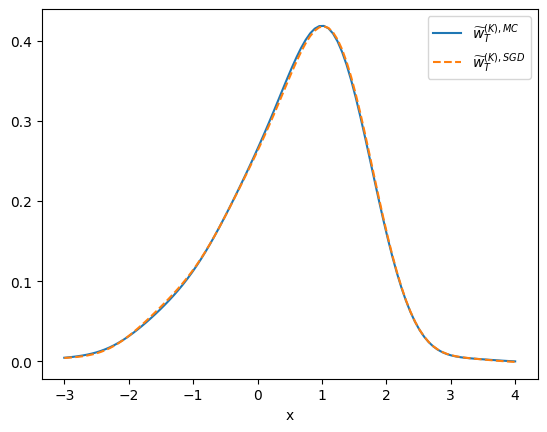

In [ ]:
# variable parameters

T = 1
N1 = 100
N = 100
K = 10
sigma = 0.1
n = 3 
M1 = 10**7
M = 100
h = T / N  
r0 = 5 #[1, 5, 10]  
rho = 0.9 #[0.7, 0.8, 0.9]
eps = 0.01


x = np.linspace(-3, 4, 100)
fig = plt.figure() 
plt.xlabel("x") 
    
for K in [10,]:

    f = factorial(K)
    alpha = fun_alpha(K, f)
    alpha1 = fun_alpha1(K, f)
    H = fun_H(K, f)
    phi1 = fun_phi1(K, f)
    a_0, g = base(T, N, n, K, f, 'lagrange')

    # # MC
    
    start = time.process_time()   # the stopwatch starts
    X, Gamma = monte_carlo(sigma, T, N1, M1, K, factorial(K))
    end = time.process_time()   # the stopwatch stops
    densityMC = np.dot( Gamma[:,-1].transpose(), (np.array(H(x)) * np.exp(-((x ** 2)/2))) )
    plt.plot(x, densityMC, label='$\widetilde{w}^{(K),MC}_T$')
    
    # SGD
    
    start = time.process_time()
    a, m = stochastic_gradient_descent(a_0, n, r0, rho, sigma, N, M, K, eps, h, g, Gamma, alpha, alpha1, H, phi1) 
    end = time.process_time() 
    print("SGD execution time: "+ str(end - start))
    print(" ")
    print("SGD steps: "+str(m))
    print(" ")
    densitySGD = np.dot( np.dot(a, g)[:,-1].transpose(), (np.array(H(x)) * np.exp(-((x ** 2)/2))) ) 
    plt.plot(x, densitySGD, '--',  label='$\widetilde{w}^{(K),SGD}_T$')
    # err = LA.norm(densitySGD - densityBM)/LA.norm(densityBM)
    # print('Err rel density K = '+str(K)+' : '+str(err))

plt.legend()
plt.savefig("DensitiesSGD.pdf")
